# Atividade de Redes Convolucionais

## Felipe Gibin

## 1. Introdução

O objetivo desse notebook é criar um modelo de classificação de núvens usando redes neurais convolucionais (CNNs). Essas redes são projetadas para processar e analisar imagens, e têm obtido grande sucesso nos últimos anos, particularmente após a concepção da AlexNet em 2010. Elas usam camadas convolucionais para aplicar filtros que extraem características gerais das imagens, e são seguidas por camadas de pooling a fim de reduzir a dimensionalidade e focar nas características mais importantes extraídas da camada anterior. Dessa forma, esse tipo de rede é ideal ao presente problema, pela sua capacidade de extrair características das imagens.

### 1.1 Bibliotecas

In [1]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models,regularizers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report, accuracy_score
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input

## 2. Pré-processamento e Organização dos Dados

### 2.1 Estrutura do Dataset

O dataset segue a seguinte estrutura:

```text
clouds/
├── cloud_train/
│   ├── cirriform clouds/
│   ├── cumulonimbus clouds/
│   ├── stratiform clouds/
│   ├── clear sky/
│   └── ... (outros tipos de nuvem)
└── cloud_test/
    ├── cirriform clouds/
    ├── cumulonimbus clouds/
    ├── stratiform clouds/
    ├── clear sky/
    └── ... (outros tipos de nuvem)
```


### 2.2 Carregar os Dados

In [2]:
drive.mount('/content/drive') # Google drive

#Caminhos para os diretórios de treino e teste
train_dir = '/content/drive/MyDrive/clouds/clouds_train'
test_dir = '/content/drive/MyDrive/clouds/clouds_test'

Mounted at /content/drive


In [6]:
#Checa a distribuição dos diretórios de treino e teste
def contar_imagens_por_classe(diretorio_base):
    total = 0
    print(f'\nDiretório: {diretorio_base}')
    for classe in os.listdir(diretorio_base):
        caminho_classe = os.path.join(diretorio_base, classe)
        if os.path.isdir(caminho_classe):
            num_imgs = len([f for f in os.listdir(caminho_classe) if os.path.isfile(os.path.join(caminho_classe, f))])
            total += num_imgs
            print(f'  Classe "{classe}": {num_imgs} imagens')
    print(f'Total de imagens em {diretorio_base}: {total}')
    return total


# Contagem
contar_imagens_por_classe(train_dir)
contar_imagens_por_classe(test_dir)



Diretório: /content/drive/MyDrive/clouds/clouds_train
  Classe "cirriform clouds": 66 imagens
  Classe "stratiform clouds": 49 imagens
  Classe "cumulonimbus clouds": 14 imagens
  Classe "stratocumulus clouds": 61 imagens
  Classe "high cumuliform clouds": 133 imagens
  Classe "clear sky": 60 imagens
  Classe "cumulus clouds": 91 imagens
Total de imagens em /content/drive/MyDrive/clouds/clouds_train: 474

Diretório: /content/drive/MyDrive/clouds/clouds_test
  Classe "cumulus clouds": 120 imagens
  Classe "stratocumulus clouds": 71 imagens
  Classe "high cumuliform clouds": 103 imagens
  Classe "stratiform clouds": 40 imagens
  Classe "clear sky": 64 imagens
  Classe "cirriform clouds": 77 imagens
  Classe "cumulonimbus clouds": 11 imagens
Total de imagens em /content/drive/MyDrive/clouds/clouds_test: 486


486

### 2.3 Dividir os dados

É preciso reorganizar o dataset de forma a aumentar a quantidade de dados em train_data. Uma divisão 50-50% é muito incomum e não faz sentido. Vamos resolver isso de forma a aumentar a proporção de train_data para 75%. Criei uma pasta nova no drive chamada clouds_all contendo todas as imagens para cada tipo de núvem, de forma que a nova estrutura dos diretórios é:

```text
clouds_all/
├── cirriform clouds/
├── cumulonimbus clouds/
├── stratiform clouds/
├── clear sky/
├── cumulus clouds/
├── high cumuliform clouds/
├── stratocumulus clouds/
```

In [3]:
# Configurações
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 123
all_data_dir = '/content/drive/MyDrive/clouds/clouds_all'

# Criar dataset completo
full_ds = image_dataset_from_directory(
    all_data_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True,
    seed=SEED
)

# Calcular tamanho do dataset
total_images = len(full_ds.file_paths)
train_size = int(0.75 * total_images)   #75% treino
val_size = int(0.1 * total_images)      #10% validacao
test_size = total_images - train_size - val_size  #15% teste

print(f"Total de imagens: {total_images}")
print(f"Treino: {train_size} | Validação: {val_size} | Teste: {test_size}")

# Criar datasets divididos
train_ds = full_ds.take(train_size // BATCH_SIZE)
remaining = full_ds.skip(train_size // BATCH_SIZE)
val_ds = remaining.take(val_size // BATCH_SIZE)
test_ds = remaining.skip(val_size // BATCH_SIZE)

Found 960 files belonging to 7 classes.
Total de imagens: 960
Treino: 720 | Validação: 96 | Teste: 144


Note que os datasets não são estratificados, ou seja, as classes não estão distribuídas igualmente nos 3 datasets. Isso se torna um certo problema mais a frente, principalmente em classes com baixa representatividade, como por exemplo `cumulunimbus clouds` que só possui 25 imagens.

### 2.3 Visualização de algumas imagens

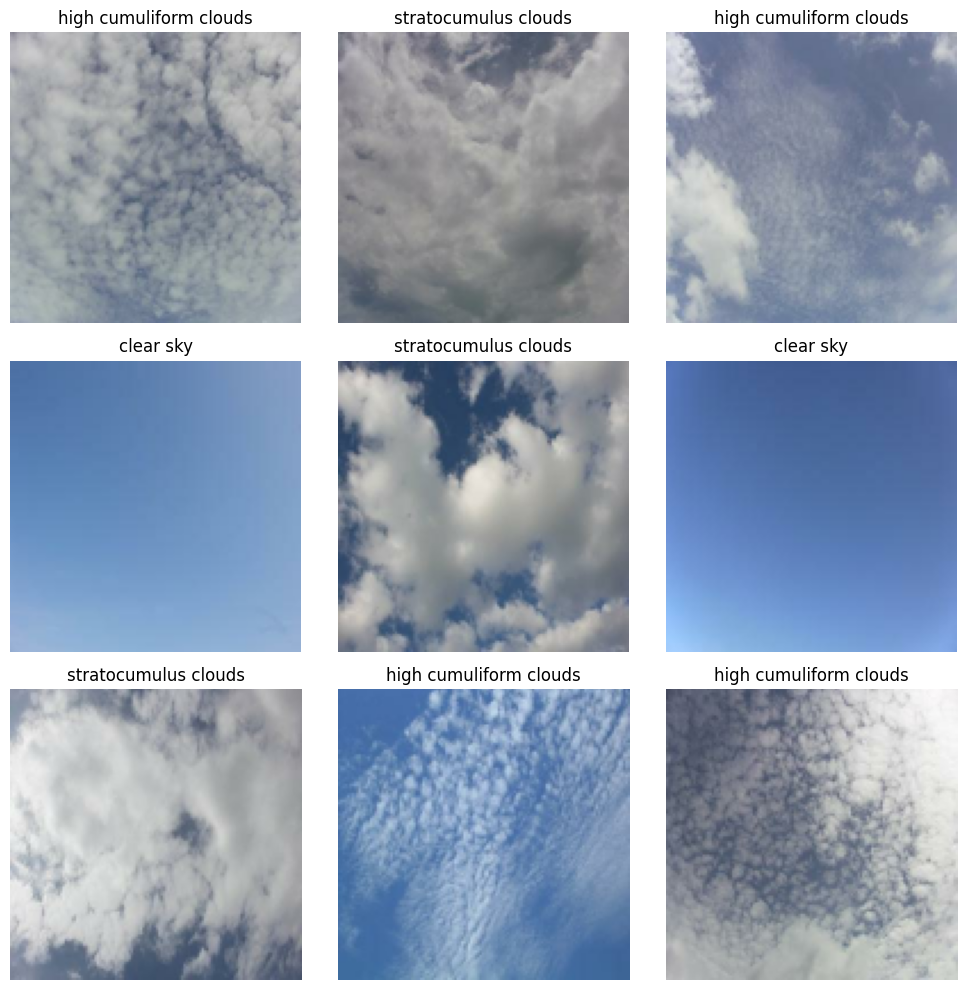

In [4]:
#Pega o nome das classes de full_ds
class_names = full_ds.class_names

# pega apenas o primeiro batch
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):  # mostrar 9 imagens aleatórias
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().argmax()])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

## 3. CNN sem data augmentation

Data augmentation é uma técnica de treinamento usada para aumentar a diversidade no conjunto de treinamento sem precisar coletar mais dados. Ela aplica algumas transformações aleatórias como zoom,rotação,flip etc, de forma a aumentar a representatividade e generalização do modelo. A fim de comparação, vamos definir um modelo sem técnicas de data augmentation e outro com.

### 3.1 Definindo o modelo

In [11]:
model_cnn_no_reg = Sequential([
    layers.Input(shape=(128,128, 3)),
    layers.Rescaling(1./255),  # Normalização

    # Blocos Convolucionais
    layers.Conv2D(32, (3, 3), activation="relu", padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu", padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu", padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),  # Processa o resultado do flatten
    layers.Dense(7, activation="softmax")  # 7 classes
])

### 3.2 Treinamento

In [14]:
model_cnn_no_reg.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_cnn_no_reg = model_cnn_no_reg.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - accuracy: 0.1832 - loss: 2.1288 - val_accuracy: 0.2292 - val_loss: 1.7244
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 641ms/step - accuracy: 0.3236 - loss: 1.6385 - val_accuracy: 0.4271 - val_loss: 1.3840
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 274ms/step - accuracy: 0.4272 - loss: 1.3423 - val_accuracy: 0.4688 - val_loss: 1.2736
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.5046 - loss: 1.1688 - val_accuracy: 0.5208 - val_loss: 1.1668
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.5373 - loss: 1.1078 - val_accuracy: 0.4896 - val_loss: 1.1704
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.5694 - loss: 1.1052 - val_accuracy: 0.5312 - val_loss: 1.1866
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.5776 - loss: 1.0390 - val_accuracy: 0.6875 - val_loss: 0.9902
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.6088 - loss: 0.9142 - val_accuracy: 0.

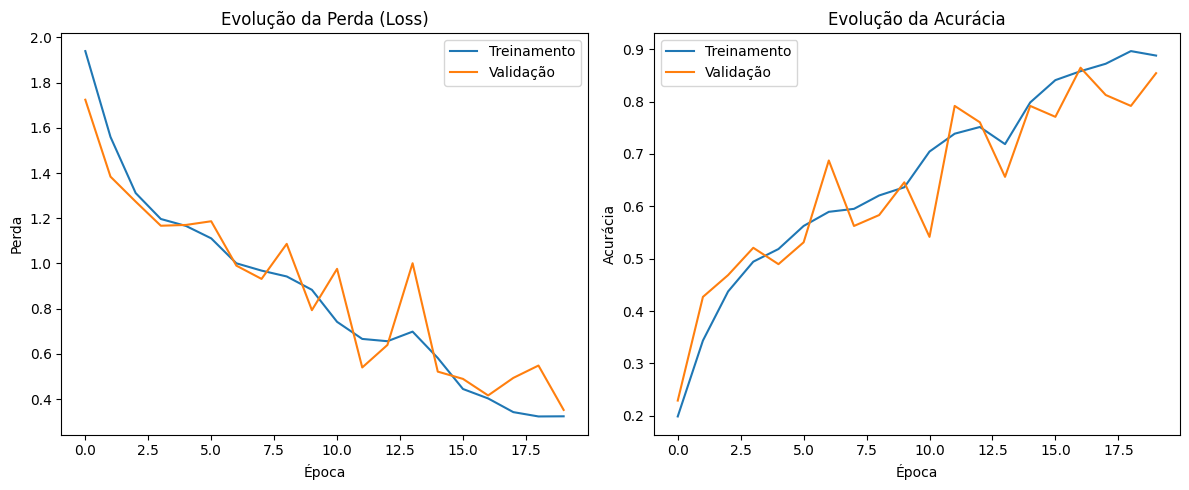

In [15]:
#Evolução das curvas de perda e acurácia

plt.figure(figsize=(12, 5))

# Curva de perda
plt.subplot(1, 2, 1)
plt.plot(history_cnn_no_reg.history['loss'], label='Treinamento')
plt.plot(history_cnn_no_reg.history['val_loss'], label='Validação')
plt.title('Evolução da Perda (Loss)')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

# Curva de acurácia
plt.subplot(1, 2, 2)
plt.plot(history_cnn_no_reg.history['accuracy'], label='Treinamento')
plt.plot(history_cnn_no_reg.history['val_accuracy'], label='Validação')
plt.title('Evolução da Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()


Não há indícios claros de overfitting no modelo, a perda e acurácia de treino e validação seguem juntas ao longo das épocas.


### 3.3 Avaliação breve

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Classes presentes: [0 1 2 3 4 5 6]


<Figure size 1200x1000 with 0 Axes>

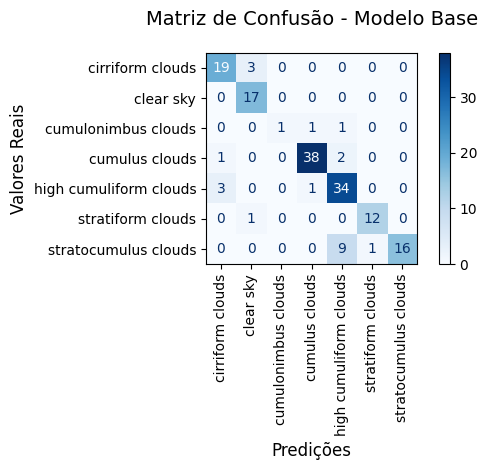

In [17]:
y_true = []
y_pred_probs = []

for images, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred_probs.extend(model_cnn_no_reg.predict(images))

y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.array(y_true)

# Garantir que todas as classes estão representadas
unique_classes = np.unique(np.concatenate([y_true, y_pred]))
print("Classes presentes:", unique_classes)

cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))

plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)

plot = disp.plot(
    cmap='Blues',
    xticks_rotation=90,
    values_format='d',
    include_values=True
)

plt.title("Matriz de Confusão - Modelo Base", pad=20, fontsize=14)
plt.xlabel('Predições', fontsize=12)
plt.ylabel('Valores Reais', fontsize=12)
plt.tight_layout()

# Verificar se há classes ausentes
if len(unique_classes) < len(class_names):
    missing = set(range(len(class_names))) - set(unique_classes)
    print(f"\nAviso: Classes ausentes nos dados de teste: {[class_names[i] for i in missing]}")

plt.show()

In [39]:
# Report básico
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

# Avaliação no conjunto de teste
test_loss, test_acc = model_cnn_no_reg.evaluate(test_ds)
print(f'\nTest Accuracy: {test_acc:.4f}')

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                        precision    recall  f1-score   support

      cirriform clouds       0.96      1.00      0.98        25
             clear sky       1.00      1.00      1.00        19
   cumulonimbus clouds       0.00      0.00      0.00         2
        cumulus clouds       0.93      0.97      0.95        38
high cumuliform clouds       0.76      0.92      0.83        38
     stratiform clouds       0.93      1.00      0.97        14
  stratocumulus clouds       0.93      0.54      0.68        24

              accuracy                           0.89       160
             macro avg       0.79      0.78      0.77       160
          weighted avg       0.89      0.89      0.88       160

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.8780 - loss: 0.3493

Test Accuracy: 0.8813


Vemos que há uma baixa representativiade da classe `cumulonimbus clouds` o que corresponde ao seu número baixo de imagens no dataset. Percebe-se que mesmo com um modelo simples, essa simplicidade foi suficiente para representar bem os dados.

## 4. CNN com regularização

### 4.1 Definindo o modelo

In [12]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.05),
    layers.RandomContrast(0.05)
])

# Construção do modelo
model_cnn = models.Sequential([
    layers.Input(shape=(128, 128, 3)),
    data_augmentation,
    layers.Rescaling(1./255),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(7, activation='softmax')  # 7 classes
])

### 4.2 Treinamento

In [13]:
model_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_cnn = model_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=1
)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 0.2056 - loss: 1.9797 - val_accuracy: 0.3438 - val_loss: 1.5997
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.3305 - loss: 1.6169 - val_accuracy: 0.4167 - val_loss: 1.3716
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.3923 - loss: 1.4553 - val_accuracy: 0.4167 - val_loss: 1.4666
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.3976 - loss: 1.5035 - val_accuracy: 0.3854 - val_loss: 1.3838
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 199ms/step - accuracy: 0.4320 - loss: 1.3688 - val_accuracy: 0.5000 - val_loss: 1.2160
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - accuracy: 0.4568 - loss: 1.3967 - val_accuracy: 0.5000 - val_loss: 1.2220
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - accuracy: 0.4568 - loss: 1.2821 - val_accuracy: 0.5208 - val_loss: 1.2178
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - accuracy: 0.4785 - loss: 1.2487 - val_accuracy: 0.

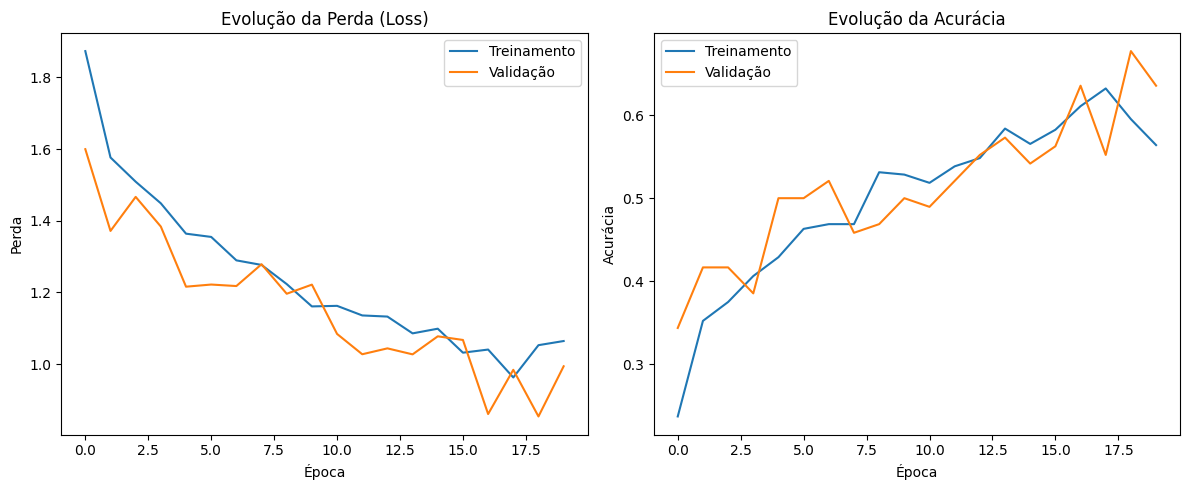

In [14]:
#Evolução das curvas de perda e acurácia

plt.figure(figsize=(12, 5))

# Curva de perda
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='Treinamento')
plt.plot(history_cnn.history['val_loss'], label='Validação')
plt.title('Evolução da Perda (Loss)')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

# Curva de acurácia
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='Treinamento')
plt.plot(history_cnn.history['val_accuracy'], label='Validação')
plt.title('Evolução da Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()

Pelo o que observamos, não há sinais claros de overfitting. A acurácia menor neste modelo pode ser explicada pelo aumento de complexidade vindo do aumento de dados. Esse aumento de complexidade exigiria um modelo mais complexo, contudo não consegui achar um equilíbrio entre complexidade e ajuste dos dados, de forma que ao adicionar regularização, houve queda no desempenho. Dito isso, mantive o melhor modelo dentre os que testei.

### 4.3 Avaliação

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Classes presentes: [0 1 2 3 4 5 6]


<Figure size 1200x1000 with 0 Axes>

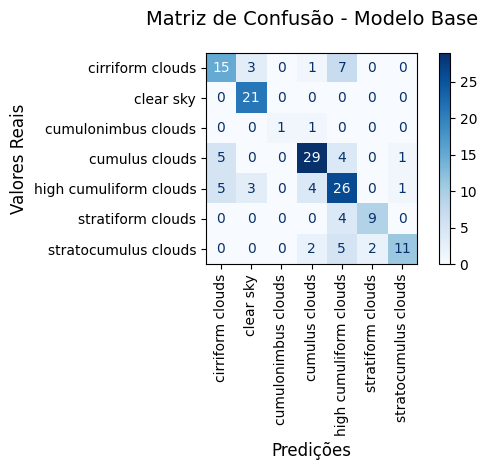

In [17]:
y_true = []
y_pred_probs = []

for images, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred_probs.extend(model_cnn.predict(images))

y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.array(y_true)

#Garantir que todas as classes estão representadas
unique_classes = np.unique(np.concatenate([y_true, y_pred]))
print("Classes presentes:", unique_classes)

cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))

plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)

plot = disp.plot(
    cmap='Blues',
    xticks_rotation=90,
    values_format='d',
    include_values=True
)

plt.title("Matriz de Confusão - Modelo Base", pad=20, fontsize=14)
plt.xlabel('Predições', fontsize=12)
plt.ylabel('Valores Reais', fontsize=12)
plt.tight_layout()

# Verificar se há classes ausentes
if len(unique_classes) < len(class_names):
    missing = set(range(len(class_names))) - set(unique_classes)
    print(f"\nAviso: Classes ausentes nos dados de teste: {[class_names[i] for i in missing]}")

plt.show()

In [18]:
# Report básico
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

# Avaliação no conjunto de teste
test_loss, test_acc = model_cnn.evaluate(test_ds)
print(f'\nTest Accuracy: {test_acc:.4f}')

                        precision    recall  f1-score   support

      cirriform clouds       0.60      0.58      0.59        26
             clear sky       0.78      1.00      0.88        21
   cumulonimbus clouds       1.00      0.50      0.67         2
        cumulus clouds       0.78      0.74      0.76        39
high cumuliform clouds       0.57      0.67      0.61        39
     stratiform clouds       0.82      0.69      0.75        13
  stratocumulus clouds       0.85      0.55      0.67        20

              accuracy                           0.70       160
             macro avg       0.77      0.68      0.70       160
          weighted avg       0.71      0.70      0.70       160

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.6060 - loss: 0.9882

Test Accuracy: 0.6187


Novamente, a baixa representatividade de algumas classes e sua distribuição não uniforma se impõem como um problema.

## 5. Transfer Learning com VGG16

Transfer Learning consiste em usar uma rede neural já treinada anteriormente como base para um novo problema. Em vez de treinar uma rede neural do zero, aproveita-se os pesos aprendidos por um modelo em uma tarefa anterior, ajustando apenas as camadas finais para a nova tarefa.

A rede VGG16 foi proposta em 2014 como uma melhora em relação as redes até então desenvolvidas, destacando-se pela sua profundidade. Assim como a Alexnet, ela venceu a competição Imagenet, famosa no ramo. Assim, vamos utilizar a rede VGG16 como pré processamento fixo das imagens, ou seja, vamos usar transfer learning com essa rede. Ainda que ela tenha sido treinada em um conjunto de dados muito mais amplo do que somente núvens, vamos verificar que podemos reusar esse treinamento para aumentar a performance do nosso problema de classificação.

### 5.1 Carregando o modelo

In [27]:
input_shape = (224, 224, 3)  # Tamanho original da VGG16

# Carregar modelo base VGG16
base_model = VGG16(
    weights="imagenet",
    include_top=False,  # Não incluir as camadas densas finais
    input_shape=input_shape
)
base_model.trainable = False  # Congelar os pesos

base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

### 5.2 Adaptando os dados ao modelo

In [37]:
def preprocess(image, label):
    #Aplica pre processamento da vgg
    image = tf.keras.applications.vgg16.preprocess_input(image)
    return image, label

train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

### 5.3 Definição e treinamento do modelo final

In [38]:
model = tf.keras.Sequential([
    base_model,                                     #Base do VGG
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(32, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),

    tf.keras.layers.Dense(7, activation='softmax')  #Camada de saída
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,322,695 (62.27 MB)

 Trainable params: 1,608,007 (6.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [39]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 343ms/step - accuracy: 0.4414 - loss: 7.8643 - val_accuracy: 0.7604 - val_loss: 3.8894
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 540ms/step - accuracy: 0.7232 - loss: 4.3508 - val_accuracy: 0.7604 - val_loss: 3.3028
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 399ms/step - accuracy: 0.8127 - loss: 3.2636 - val_accuracy: 0.9167 - val_loss: 2.7562
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 479ms/step - accuracy: 0.8575 - loss: 2.8808 - val_accuracy: 0.8958 - val_loss: 2.6622
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 427ms/step - accuracy: 0.8554 - loss: 2.8415 - val_accuracy: 0.9271 - val_loss: 2.4831
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 490ms/step - accuracy: 0.8952 - loss: 2.7879 - val_accuracy: 0.9062 - val_loss: 2.3530
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 365ms/step - accuracy: 0.9108 - loss: 2.3292 - val_accuracy: 0.9583 - val_loss: 2.0549
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 553ms/step - accuracy: 0.9108 - loss: 2.2494 - val_accu

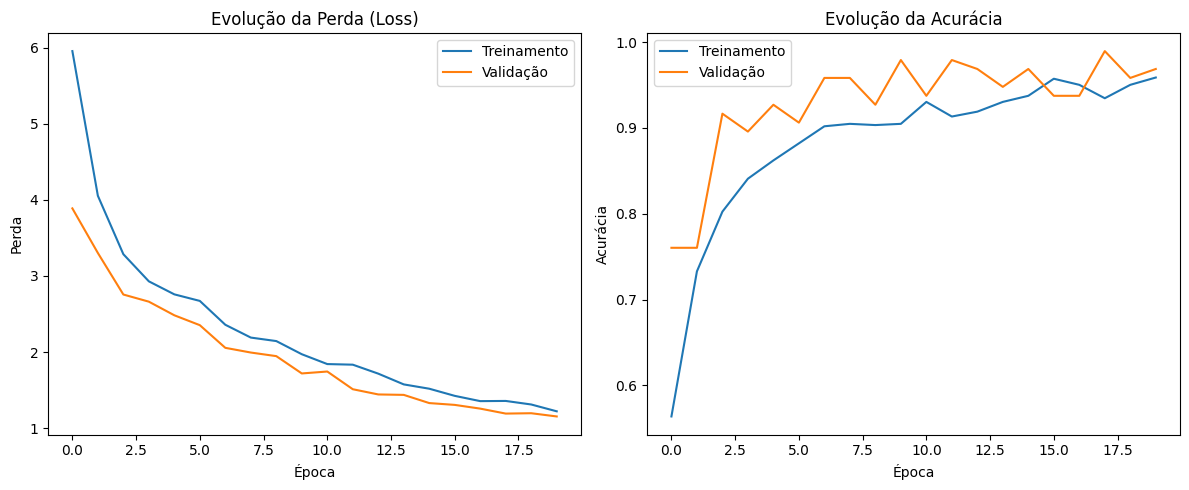

In [40]:
#Evolução das curvas de perda e acurácia

plt.figure(figsize=(12, 5))

# Curva de perda
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Evolução da Perda (Loss)')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

# Curva de acurácia
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Evolução da Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()

### 5.4 Avaliação

y_true: 160, y_pred: 160


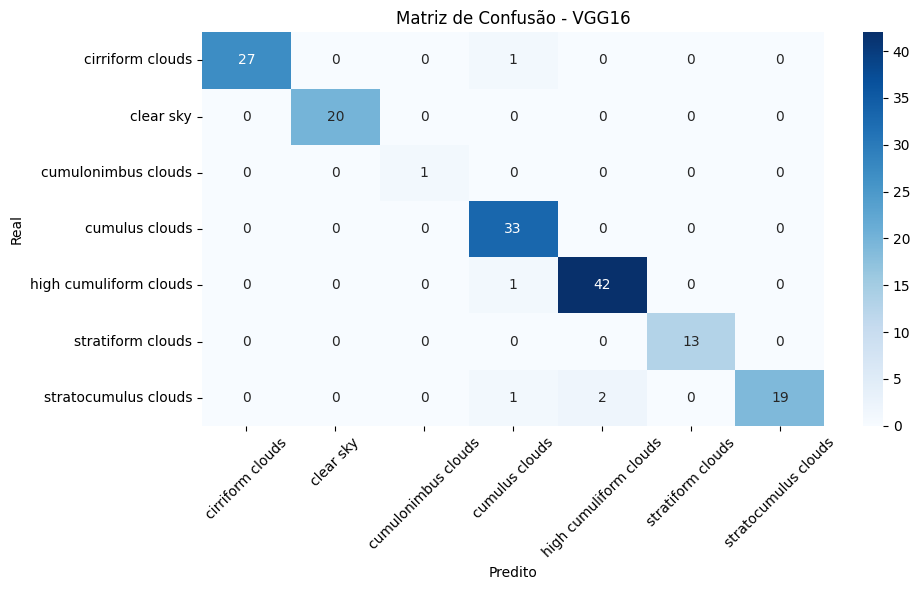

In [54]:
y_pred = []
y_true = []

for batch_images, batch_labels in test_ds:
    preds = model.predict(batch_images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(batch_labels.numpy(), axis=1))

y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Confirmação de tamanhos iguais
print(f"y_true: {len(y_true)}, y_pred: {len(y_pred)}")

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão - VGG16')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [55]:
#Report básico
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

# Avaliação no conjunto de teste
test_loss, test_acc = model.evaluate(test_ds)
print(f'\nTest Accuracy: {test_acc:.4f}')

                        precision    recall  f1-score   support

      cirriform clouds       1.00      0.96      0.98        28
             clear sky       1.00      1.00      1.00        20
   cumulonimbus clouds       1.00      1.00      1.00         1
        cumulus clouds       0.92      1.00      0.96        33
high cumuliform clouds       0.95      0.98      0.97        43
     stratiform clouds       1.00      1.00      1.00        13
  stratocumulus clouds       1.00      0.86      0.93        22

              accuracy                           0.97       160
             macro avg       0.98      0.97      0.98       160
          weighted avg       0.97      0.97      0.97       160

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 275ms/step - accuracy: 0.9633 - loss: 1.1282

Test Accuracy: 0.9563


Observamos um desempenho muito superior aos outros 2 modelos. A base da VGG16 permitiu um ajuste muito melhor aos dados do dataset, mesmo que essa rede não tenha sido treinada especificamente para classificação de núvens.

## 6. Conclusões

Definimos e treinamos 3 redes neurais convolucionais, todas voltadas para o problema de classificação de núvens. Das 3, a que usa o transfer learning com a VGG16 teve o melhor desempenho, o que não surpreende dada a profundidade da rede e a diversidade dos dados de treinamento dela.

Como grande limitação do problema, a falta de estratificação e balanceamento do dataset dificultaram tanto o treinamento quanto a avaliação dos modelos. O balanceamento do dataset é um problema intrínseco dele, em que sua solução depende da adição de imagens nas classes menos representadas. Já a estratificação do conjunto de dados é um problema solucionável, desde que tome-se o tempo necessário para dividir as imagens de forma uniforme nos conjuntos de treino, validação e teste.

Apesar dessas limitações, os modelos obtiveram bons resultados e o problema de classificação de nuvens foi resolvido de forma satisfatória, embora com espaço para melhorias.